In [37]:
import pandas as pd
import cv2

In [38]:
import os

pasta = "dataset_todo/"

def files_path04(path):
    infos =[]
    for p, _, files in os.walk(os.path.abspath(path)):
        for file in files:
            infos.append(os.path.join(p, file))
    return infos

dados = files_path04(pasta)

In [39]:
tipo = [i.split("\\")[-3] for i in dados]
subgroup = [i.split("\\")[-2] for i in dados]
filename = [i.split("\\")[-1] for i in dados]
classe = [0 if x == "benigno" else 1 for x in tipo  ]

In [40]:
df = pd.DataFrame()

In [41]:
df['filename'] = filename
df['subgroup'] = subgroup
df['tipo'] = tipo
df['classe'] = classe

In [42]:
df

,filename,subgroup,tipo,classe
0,benigno10.png,53453eb2e4b05911cd6db1378,benigno,0
1,benigno11.png,53453eb2e4b05911cd6db1378,benigno,0
2,benigno12.png,53453eb2e4b05911cd6db1378,benigno,0
3,benigno13.png,53453eb2e4b05911cd6db1378,benigno,0
4,benigno210.png,53453eb2e4b05911cd6db1379,benigno,0
...,...,...,...,...
5620,maligno3077.png,53454d61e4b05911cd6db51aNodule 005,maligno,1
5621,maligno3078.png,53454d61e4b05911cd6db51aNodule 005,maligno,1
5622,maligno3079.png,53454d61e4b05911cd6db51aNodule 005,maligno,1
5623,maligno3080.png,53454d72e4b05911cd6db51dNodule 002,maligno,1


In [43]:
import seaborn as sns

<AxesSubplot:xlabel='tipo', ylabel='Count'>

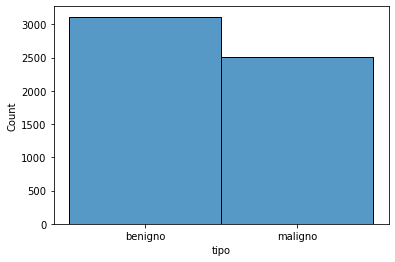

In [44]:
sns.histplot(df['tipo'])

In [45]:
df['tipo'].value_counts()

benigno    3115
maligno    2510
Name: tipo, dtype: int64

In [46]:
benignos_sub = df[df['tipo']=='benigno']['subgroup'].unique()
malignos_sub = df[df['tipo']=='maligno']['subgroup'].unique()

In [47]:
import random
random.seed(42)

In [48]:
random.shuffle(benignos_sub)
random.shuffle(malignos_sub)

In [49]:

def split(lista, folds):
    index=[]
    pivo = int(len(lista)/folds)
    for i in range(folds+1):
        index.append(lista[i*pivo:pivo*(i+1)])
    return index

folds = 6
index_benignos = split(benignos_sub,folds)
index_malignos = split(malignos_sub,folds)


In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [51]:
width = 64
height = 64
IMAGE_SIZE = (width,height)
num_densa = 1024
channels = 3
num_out = 1


In [52]:
import numpy as np

In [53]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [54]:
def concat_treino_idx(accessed_list):
    out =[]
    for i in accessed_list:
        for j in i:
            out.append(j)
    return out

In [55]:
def images_por_fold(index_benignos,treino_idx,teste_idx,val_idx,tipo):
    treino_idx.remove(val_idx)
    treino_idx.remove(teste_idx)
    accessed_mapping = map(index_benignos.__getitem__, treino_idx)
    accessed_list = list(accessed_mapping)
    treino_idx = concat_treino_idx(accessed_list)
    
    treino = images_labels(treino_idx,tipo)
    val = images_labels(index_benignos[val_idx],tipo)
    teste = images_labels(index_benignos[teste_idx],tipo)
    return treino,val,teste
    

In [56]:

def images_labels(indexs,tipo):
    first = True
    for i in indexs:

        imagens = df[(df['subgroup']==i)& (df['tipo']==tipo)]['filename'].values
        X_train = np.zeros((len(imagens), width, height, channels))

        for idx,j in  enumerate(imagens):
            X_train[idx] =  np.asarray(cv2.resize(NormalizeData(cv2.imread(pasta+tipo+"/"+i+"/"+j))*255, (64,64), interpolation = cv2.INTER_AREA))

        X_train = X_train.reshape(( X_train.shape[0],) +(width, height,channels)).astype('float32') / 255. 
        if first:
            out = X_train
        else:
            out = np.concatenate((X_train,out))  
        first = False
    return out
    

In [57]:
from keras.preprocessing.image import ImageDataGenerator
num_densa= 1024

In [58]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

In [59]:
def images_labels_arg(imagens,path_arg):
    
    
    first = True
    X_train = np.zeros((len(imagens), width, height, channels))
    for idx,i in enumerate(imagens):
        
        X_train[idx] =  np.asarray(cv2.resize(NormalizeData(cv2.imread(path_arg+i))*255, (64,64), interpolation = cv2.INTER_AREA))

    X_train = X_train.reshape(( X_train.shape[0],) +(width, height,channels)).astype('float32') / 255. 
    return X_train

In [60]:
def get_arg(treino_b,quant_imag_b,path_arg_b ):

    datagen_b = ImageDataGenerator(horizontal_flip=True,rotation_range=30,zoom_range=[0.7,1.0])
    it_b = datagen_b.flow(treino_b, batch_size=1)
    
    for i in range(quant_imag_b):
        batch = it_b.next()
        cv2.imwrite(path_arg_b+str(i)+"arg_.png",batch.squeeze()*255)
        
    dados_ags_b = files_path04(path_arg_b)
    filename_arg_b = [i.split("\\")[-1] for i in dados_ags_b]
    return images_labels_arg(filename_arg_b,path_arg_b)

In [61]:
import gc

In [65]:
def clear():
    tf.keras.backend.clear_session()
    gc.collect()

In [ ]:
clear()

In [ ]:
clear()

In [ ]:
clear()

In [66]:
def sufller(X,y):
    rando_aux = list(zip(X, y))
    random.shuffle(rando_aux)
    X, y = zip(*rando_aux)    
    X = np.array(X).squeeze()
    y = np.asarray(y)
    return X,y

In [67]:
def treinar_modelo(modelo,X_train, y_train,X_val, y_val,X_teste):
    
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    
    modelo.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    
    modelo.fit(X_train, y_train,batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[es])
    
    return modelo.predict(X_teste)
    
    

In [68]:
batch_size_gan = 64

def create_batch(x_train):
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)


    dataset = dataset.batch(batch_size_gan, drop_remainder = True).prefetch(1)

    return dataset

In [69]:
from tensorflow.keras import models

In [83]:
def get_cnn_Custom():
    #Igual da minha tese
    model = models.Sequential()
    model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.Dropout(0.4))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.4))
    #model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_densa*2, activation="relu"))
    model.add(layers.Dense(num_densa*2, activation="relu"))
    model.add(layers.Dense(num_out, activation="sigmoid"))
    
    return model

In [84]:
clear()
clear()
clear()
clear()

In [85]:
import matplotlib.pyplot as plt

In [86]:
quant_imag_b =10000
range_misto_b = int(quant_imag_b/4)
path_arg_b = "aumentos/aumento_b_v2/"

quant_imag_m =10000
range_misto_m = int(quant_imag_m/4)
path_arg_m = "aumentos/aumento_m_v2/"

#resultado clássico


cust_result =[]


y_test_list =[]

val_idx = 1
teste_idx = 2

threshold =0.5
batch_size = 16
num_epochs = 200

#for i in range(2):
for i in range(folds):
    print("Folds: ",i)
    print("Carregando dados")
    #ler dados
    tipo = "benigno"
    treino_idx = [item for item in range(folds)]
    treino_b,val_b,teste_b = images_por_fold(index_benignos,treino_idx,teste_idx,val_idx,tipo)
    
    tipo = "maligno"
    treino_idx = [item for item in range(folds)]
    treino_m,val_m,teste_m = images_por_fold(index_malignos,treino_idx,teste_idx,val_idx,tipo)
    
    
    #SEM USAR OS DADOS ORIGINAIS:
    treino_b_arg_classico = get_arg(treino_b,quant_imag_b,path_arg_b)
    treino_m_arg_classico = get_arg(treino_m,quant_imag_m,path_arg_m)
    
    
    treino_b_label = np.repeat(0, len(treino_b_arg_classico))
    val_b_label = np.repeat(0, len(val_b))
    teste_b_label = np.repeat(0, len(teste_b))
    
    treino_m_label = np.repeat(1, len(treino_m_arg_classico))
    val_m_label = np.repeat(1, len(val_m))
    teste_m_label = np.repeat(1, len(teste_m))
    
    #Aumento com classico
    X_train = np.concatenate((treino_b_arg_classico,treino_m_arg_classico))
    y_train = np.concatenate((treino_b_label,treino_m_label))
    
    X_train, y_train = sufller(X_train, y_train)
    
    
    
    #Cortando o malignos para ficar igual
    X_val = np.concatenate((val_b,val_m[:len(val_b)]))
    y_val = np.concatenate((val_b_label,val_m_label[:len(val_b_label)]))
    
    
    X_val, y_val = sufller(X_val, y_val)
    
    #Cortando o malignos para ficar igual
    X_teste = np.concatenate((teste_b,teste_m[:len(teste_b)]))
    y_teste = np.concatenate((teste_b_label,teste_m_label[:len(teste_b_label)]))
    
    X_teste, y_teste = sufller(X_teste, y_teste)
    
    y_test_list.append(y_teste)
    
    print("Inicio do treinamento")
    print()
    
    
    
    
    #Custom
    print("----------")
    print("Custom")
    model = get_cnn_Custom()
    cust_result.append(treinar_modelo(model,X_train, y_train,X_val, y_val,X_teste))
    clear()
    clear()
    
    val_idx = val_idx + 1
    if val_idx>= folds:
        val_idx = 0
    teste_idx = teste_idx + 1
    if teste_idx>= folds:
        teste_idx = 0
    break

Folds:  0
Carregando dados
Inicio do treinamento

----------
Custom
Epoch 1/200
1250/1250 [==============================] - 23s 18ms/step - loss: 0.5030 - accuracy: 0.7666 - val_loss: 0.5424 - val_accuracy: 0.7629
Epoch 2/200
1250/1250 [==============================] - 23s 18ms/step - loss: 0.3991 - accuracy: 0.8197 - val_loss: 0.5258 - val_accuracy: 0.7414
Epoch 3/200
1250/1250 [==============================] - 23s 18ms/step - loss: 0.3075 - accuracy: 0.8661 - val_loss: 0.5266 - val_accuracy: 0.7178
Epoch 3: early stopping


In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 dropout (Dropout)           (None, 62, 62, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                    

In [93]:
import scipy as sp
import tensorflow.keras.backend as K

def get_CAM(processed_image, actual_label, layer_name='conv2d_2'):
    model_grad = tf.keras.models.Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)
        tape.watch(conv_output_values)
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        loss = tf.keras.losses.binary_crossentropy(tf.transpose(actual_label), predictions[0])
      
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    # weight the convolution outputs with the computed gradients
    for i in range(64): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap, predictions[0]

In [94]:
import random
import cv2
def show_sample(idx=0):
    
    sample_image = X_teste[idx]
    sample_label = y_teste[idx]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
       
    heatmap, pred = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.astype('float32')
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(1,3, figsize=(12,8))
    #print(sample_image.shape)
    ax[0].imshow(sample_image)
    ax[0].set_title(f"Predicted label: {pred}")
    ax[0].axis('off')
    
    ax[1].imshow(heatmap)
    ax[1].set_title("Class Activation Map")
    ax[1].axis('off')
    
    ax[2].imshow(super_imposed_image)
    ax[2].set_title("Activation map superimposed")
    ax[2].axis('off')
    plt.tight_layout()
    plt.show()

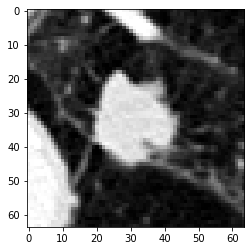

In [108]:
plt.imshow(X_teste[exemplo])

In [118]:
import random

True: 
1
Predição: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


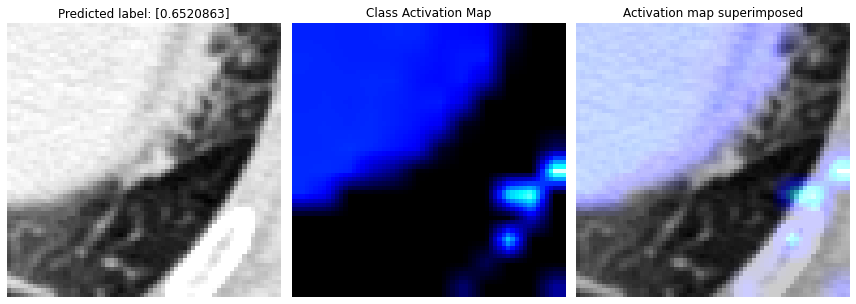

In [120]:
exemplo = random.randint(0, len(y_teste))
print("True: ")
print(y_teste[exemplo])
print("Predição: ")
print(np.where(model.predict(X_teste)[exemplo]> threshold, 1,0)[0])
show_sample(idx=exemplo)